# Prototype v1

Prototype for the entire bioinformatics framework (PPM + weighted point + CPD + knn).

In [95]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pycpd import RigidRegistration
from sklearn.neighbors import KNeighborsClassifier


# Generate toy data

Simulate two populations, two markers, slightly shifted.

Text(0.5, 1.0, 'Toy dataset with 2 populations and 2 batches')

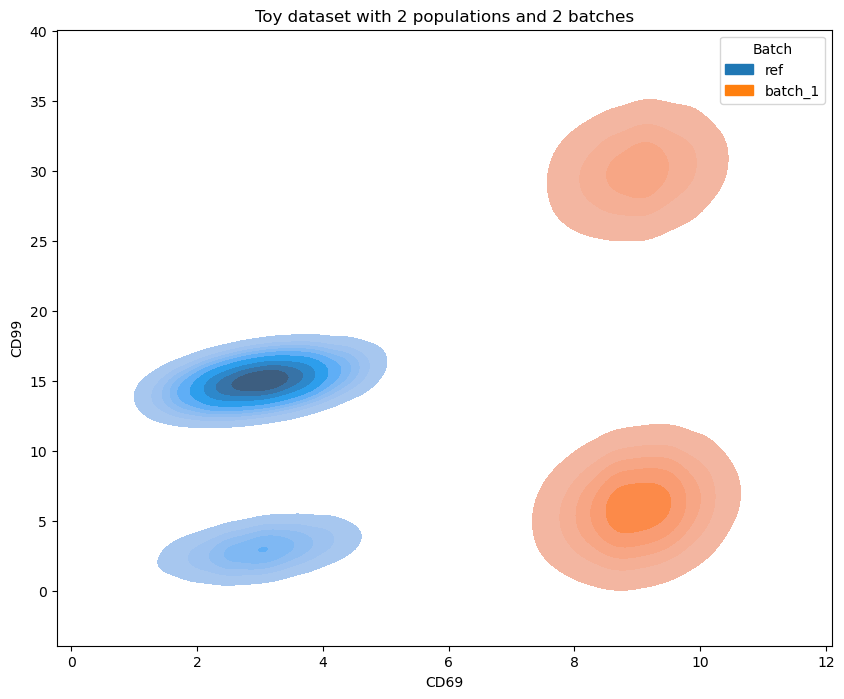

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Configuration
num_points = 300  # Per cluster
cov = [[0.5, 0.3], [0.3, 0.5]]  # Shared covariance matrix

# Generate four Gaussian clusters
means = [
    [3, 15],   # Top-left (original)
    [9, 30],  # Top-right (shifted up by +2)
    [3, 3],  # Bottom-left
    [9, 6]    # Bottom-right (shifted right to x=5)
]

population_names = ["pop_1", "pop_1", "pop_2", "pop_2"]
batches = ["ref", "batch_1", "ref", "batch_1"]
n_points = [10000, 3000, 2000, 6000]

dat = []
for x_idx, mean in enumerate(means):
    vals = np.random.multivariate_normal(mean, cov, n_points[x_idx])
    # concatenate the content of the array as columns
    dat.append(np.c_[
        vals, 
        np.full(n_points[x_idx], population_names[x_idx]),
        np.full(n_points[x_idx], batches[x_idx])
    ])

# Combine into single array
dat = np.vstack(dat)

# Create DataFrame
df = pd.DataFrame(dat, columns=['CD69', 'CD99', 'Population', "Batch"])
df[['CD69', 'CD99']] = df[['CD69', 'CD99']].astype(float)

# Plotting
# _, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
# sns.scatterplot(data=df, x='CD69', y='CD99', hue='Batch', style='Population', 
#                 palette='viridis', alpha=0.7, edgecolor='none', ax=ax)
# ax.set_title('Toy dataset with 2 populations and 2 batches')
# plt.grid(True)
# # plt.legend(title='Cluster')
# plt.show()

_, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
sns.kdeplot(
    data=df, x="CD69", y="CD99", hue="Batch", fill=True, ax=ax
)
ax.set_title('Toy dataset with 2 populations and 2 batches')


In [98]:
min(df[(df['Batch'] == 'ref') & (df['Population'] == 'pop_1')]['CD99'])

12.369013614172724

In [ ]:
df.to_csv("../data/toy_data_2batches_2pops.csv")

# PPM

Just use 2d histogram binning..

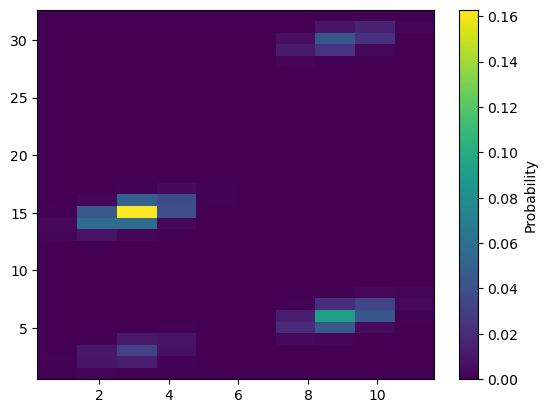

In [4]:
# cartesian plotting and numpy 2d histogram has 2 different orientation.
# 1st argument in histogram is rows, hence must be y-axis.
# 2nd argument in histogram is columns, hence must be x-axis.

x_vals = df['CD69'].values
y_vals = df['CD99'].values

# x then y (x=10, y=32)
grid_size = [10, 32]
ppm, xedges, yedges = np.histogram2d(x_vals, y_vals, bins=grid_size)
# Normalize to get probabilities
total_cells = df.shape[0]
ppm = ppm / total_cells

# When you compute a 2D histogram with np.histogram2d(x, y), NumPy:
# Bins x-values vertically (along rows/first dimension).
# Bins y-values horizontally (along columns/second dimension).
# transpose will Swap rows to columns and vice versa
ppm = ppm.T

pc = plt.pcolormesh(xedges, yedges, ppm, 
                    shading='auto', cmap='viridis')
plt.colorbar(pc, label='Probability')

plt.show()



In [6]:
# get position and index of bins
bin_coords = []
bin_id = 0
for x_idx in range(len(xedges)-1):
    for y_idx in range(len(yedges)-1):
        bin_coords.append([
            f"bin_{bin_id}",
            xedges[x_idx],
            xedges[x_idx+1],
            yedges[y_idx],
            yedges[y_idx+1],
            ppm[y_idx, x_idx]
        ])
        bin_id += 1
bin_coords = pd.DataFrame(bin_coords, columns=["bin_id", "xmin", "xmax", "ymin", "ymax", "prob"])
bin_coords

,bin_id,xmin,xmax,ymin,ymax,prob
0,bin_0,0.219061,1.360562,0.537763,1.540468,0.000429
1,bin_1,0.219061,1.360562,1.540468,2.543172,0.000667
2,bin_2,0.219061,1.360562,2.543172,3.545877,0.000095
3,bin_3,0.219061,1.360562,3.545877,4.548582,0.000000
4,bin_4,0.219061,1.360562,4.548582,5.551287,0.000000
...,...,...,...,...,...,...
315,bin_315,10.492576,11.634078,27.610792,28.613497,0.000000
316,bin_316,10.492576,11.634078,28.613497,29.616202,0.000000
317,bin_317,10.492576,11.634078,29.616202,30.618906,0.000286
318,bin_318,10.492576,11.634078,30.618906,31.621611,0.001619


Let's try PPM per "batch", pretending we will have the PPM map for the reference already.

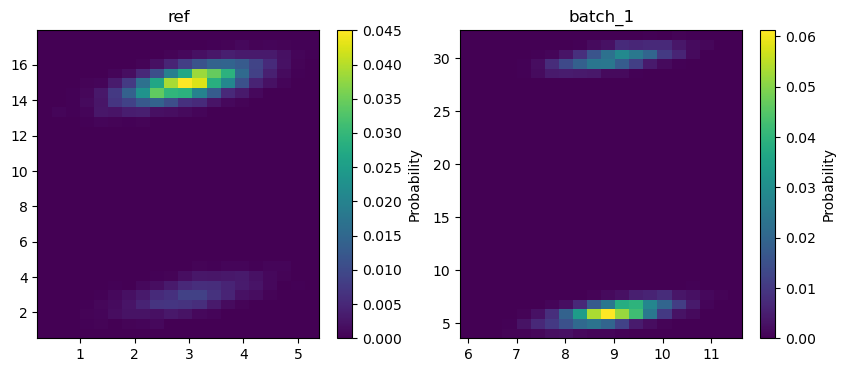

In [7]:
# cartesian plotting and numpy 2d histogram has 2 different orientation.
# 1st argument in histogram is rows, hence must be y-axis.
# 2nd argument in histogram is columns, hence must be x-axis.

batches = ['ref', 'batch_1']

bin_coords_df = []

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ppms = {}

for batch_id, batch in enumerate(batches):

    # cartesian plotting and numpy 2d histogram has 2 different orientation.
    # 1st argument in histogram is rows, hence must be y-axis.
    # 2nd argument in histogram is columns, hence must be x-axis.

    df_batch = df[df['Batch'] == batch]

    x_vals = df_batch['CD69'].values
    y_vals = df_batch['CD99'].values

    grid_size = [20, 32]
    ppm, xedges, yedges = np.histogram2d(x_vals, y_vals, bins=grid_size)

    # print(ppm)
    # Normalize to get probabilities
    total_cells = df_batch.shape[0]
    ppm = ppm / total_cells

    # When you compute a 2D histogram with np.histogram2d(x, y), NumPy:
    # Bins x-values vertically (along rows/first dimension).
    # Bins y-values horizontally (along columns/second dimension).
    # transpose will Swap rows to columns and vice versa
    ppm = ppm.T

    ppms[batch] = ppm

    # get position and index of bins
    bin_coords = []
    bin_id = 0
    for x_idx in range(len(xedges)-1):
        for y_idx in range(len(yedges)-1):
            bin_coords.append([
                f"bin_{bin_id}",
                xedges[x_idx],
                xedges[x_idx+1],
                yedges[y_idx],
                yedges[y_idx+1],
                ppm[y_idx, x_idx]
            ])
            bin_id += 1
    bin_coords = pd.DataFrame(bin_coords, columns=["bin_id", "xmin", "xmax", "ymin", "ymax", "prob"])
    bin_coords['Batch'] = batch
    bin_coords_df.append(bin_coords)

    # plot
    pc = ax[batch_id].pcolormesh(xedges, yedges, ppm, shading='auto', cmap='viridis')
    fig.colorbar(pc, label='Probability', ax=ax[batch_id])
    ax[batch_id].set_title(batch)

bin_coords_df = pd.concat(bin_coords_df)


plt.show()

In [8]:
bin_coords_df['x_center'] = bin_coords_df['xmin'] + ((bin_coords_df['xmax'] - bin_coords_df['xmin'])/2)
bin_coords_df['y_center'] = bin_coords_df['ymin'] + ((bin_coords_df['ymax'] - bin_coords_df['ymin'])/2)
bin_coords_df

,bin_id,xmin,xmax,ymin,ymax,prob,Batch,x_center,y_center
0,bin_0,0.219061,0.477658,0.537763,1.082229,0.000000,ref,0.348359,0.809996
1,bin_1,0.219061,0.477658,1.082229,1.626695,0.000000,ref,0.348359,1.354462
2,bin_2,0.219061,0.477658,1.626695,2.171162,0.000000,ref,0.348359,1.898928
3,bin_3,0.219061,0.477658,2.171162,2.715628,0.000000,ref,0.348359,2.443395
4,bin_4,0.219061,0.477658,2.715628,3.260094,0.000000,ref,0.348359,2.987861
...,...,...,...,...,...,...,...,...,...
635,bin_635,11.344249,11.634078,28.085729,28.993447,0.000000,batch_1,11.489163,28.539588
636,bin_636,11.344249,11.634078,28.993447,29.901164,0.000000,batch_1,11.489163,29.447305
637,bin_637,11.344249,11.634078,29.901164,30.808881,0.000000,batch_1,11.489163,30.355023
638,bin_638,11.344249,11.634078,30.808881,31.716599,0.000111,batch_1,11.489163,31.262740


Text(0.5, 1.0, 'PPM Batch 1 data')

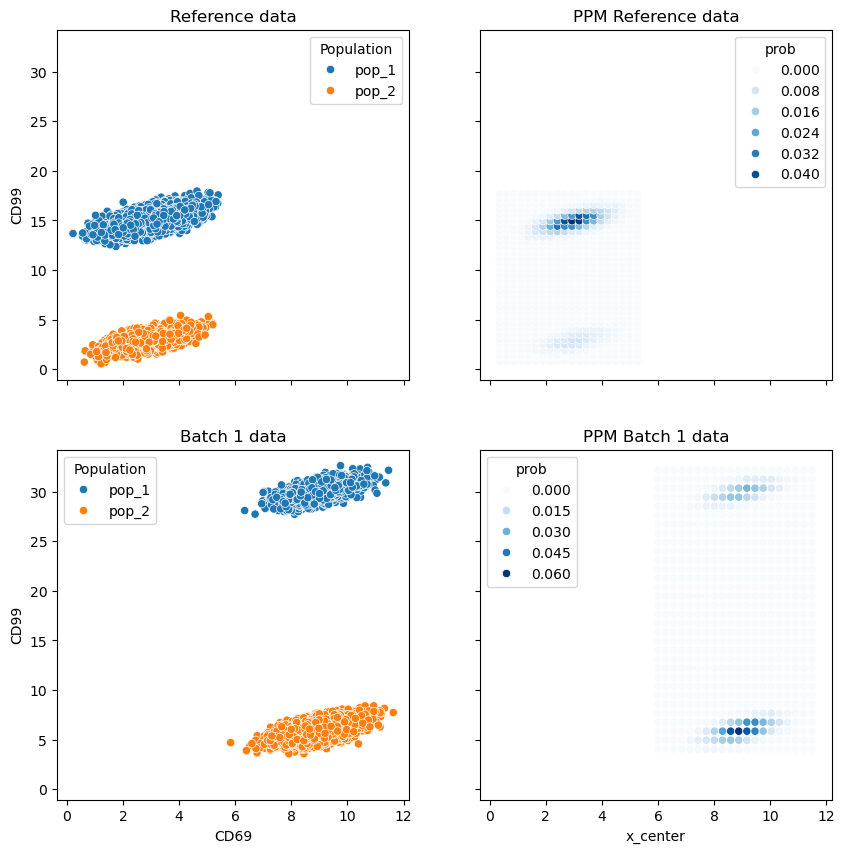

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)

# plot the reference data first
sns.scatterplot(
    data=df[df['Batch'] == 'ref'],
    x='CD69',
    y='CD99',
    hue='Population',
    ax=ax[0][0]
).set_title("Reference data")

# plot the reference data first
sns.scatterplot(
    data=bin_coords_df[bin_coords_df['Batch'] == 'ref'],
    x='x_center',
    y='y_center',
    hue='prob',
    ax=ax[0][1],
    palette='Blues'
).set_title("PPM Reference data")

# plot the reference data first
sns.scatterplot(
    data=df[df['Batch'] == 'batch_1'],
    x='CD69',
    y='CD99',
    hue='Population',
    ax=ax[1][0]
).set_title("Batch 1 data")

# plot the reference data first
sns.scatterplot(
    data=bin_coords_df[bin_coords_df['Batch'] == 'batch_1'],
    x='x_center',
    y='y_center',
    hue='prob',
    ax=ax[1][1],
    palette='Blues'
).set_title("PPM Batch 1 data")

# Weighted point set

From PPM, generate weighted points which focus on high probability area and treat low probability area as noise.

In [81]:
# minimum probability to sample the points from
probability_threshold=0.0005
# whether to generate more points around area with high probability or not
adaptive_sampling=True
# max cell per bin cell, i.e., upper limit for how many points can be generated 
# in the bin cell with the highest probability.
max_points_per_cell=10

grid_size = ppms['ref'].shape
max_prob = ppms['ref'].max()

bin_coords_df_ref = bin_coords_df[bin_coords_df['Batch'] == 'ref']

# Get coordinates of bins above threshold
bin_coords_over_threshold = bin_coords_df_ref[bin_coords_df_ref['prob'] > probability_threshold]

probabilities = bin_coords_over_threshold['prob']
x_coords = bin_coords_over_threshold['x_center'].to_numpy()
y_coords = bin_coords_over_threshold['y_center'].to_numpy()

if adaptive_sampling:
    # Calculate number of points per grid cell
    
    # TODO not sure about this....
    # probabilities is already scaled to the number of points in the data..
    # a cell's probability scaled relative to the maximum probability in the entire PPM.
    normalized_prob = probabilities / max_prob

    num_points = np.maximum(1, 
        np.ceil(normalized_prob * max_points_per_cell).astype(int))
    
    # Generate jitter for all points at once
    total_points = num_points.sum()
    jitter = np.random.uniform(0.1, 0.9, (total_points, 2))
    
    # Convert cell indices to coordinates

    # cell_indices generate num_points (number of array per bin) elements per bin coords (x_coords)
    # cell_indices = np.repeat(np.arange(len(x_coords)), num_points)
    x_cells = np.repeat(x_coords, num_points)
    y_cells = np.repeat(y_coords, num_points)
    
    # Calculate final positions
    # Dividing by grid_size maps discrete grid indices to a continuous, 
    # normalized coordinate system-typically to ensure all points fit within a standardized range 
    # because x_coords (which was used for x_cells) are already based on the coordinates from ref_data,
    # we don't need to take into account the grid_size
    points = np.column_stack([
        (x_cells + jitter[:, 0]),
        (y_cells + jitter[:, 1])
    ])
    weights = np.repeat(probabilities, num_points)
else:
    # TODO, need fixing
    # Single point per cell at center
    points_x = []
    points_y = []
    for x, y in zip(x_coords, y_coords):
        x_centre = (xedges[x_coords] + xedges[x_coords+1])/2
        y_centre = (yedges[y_coords] + yedges[y_coords+1])/2

        # normalise the centre by the grid size
        x_centre = x_centre / grid_size[0] * 100
        y_centre = y_centre / grid_size[1] * 100

        points_x.append(x_centre)
        points_y.append(y_centre)

    points = np.column_stack([points_x, points_y])
    weights = probabilities

# Normalize weights
weights /= weights.sum()

Text(0.5, 1.0, 'wegithed point set')

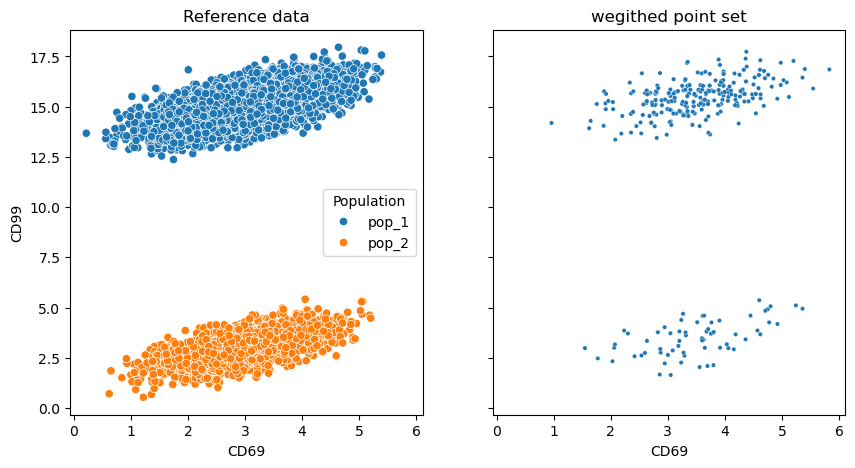

In [82]:
points_df = pd.DataFrame(points)
points_df.columns = ['CD69', 'CD99']
points_df['weight'] = weights.to_numpy()
points_df


fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)

# plot the reference data first
sns.scatterplot(
    data=df[df['Batch'] == 'ref'],
    x='CD69',
    y='CD99',
    hue='Population',
    ax=ax[0]
).set_title("Reference data")

sns.scatterplot(
    data=points_df,
    x='CD69',
    y='CD99',
    s=10+(weights*100),
    ax=ax[1]
).set_title("wegithed point set")


Still not sure what the weights is used here.. 

Generate points for batch 1.

In [83]:
# minimum probability to sample the points from
probability_threshold=0.0005
# whether to generate more points around area with high probability or not
adaptive_sampling=True
# max cell per bin cell, i.e., upper limit for how many points can be generated 
# in the bin cell with the highest probability.
max_points_per_cell=10

grid_size = ppms['ref'].shape
max_prob = ppms['ref'].max()

bin_coords_df_batch = bin_coords_df[bin_coords_df['Batch'] == 'batch_1']

# Get coordinates of bins above threshold
bin_coords_over_threshold_batch = bin_coords_df_batch[bin_coords_df_batch['prob'] > probability_threshold]

probabilities = bin_coords_over_threshold_batch['prob']
x_coords = bin_coords_over_threshold_batch['x_center'].to_numpy()
y_coords = bin_coords_over_threshold_batch['y_center'].to_numpy()

if adaptive_sampling:
    # Calculate number of points per grid cell
    
    # TODO not sure about this....
    # probabilities is already scaled to the number of points in the data..
    # a cell's probability scaled relative to the maximum probability in the entire PPM.
    normalized_prob = probabilities / max_prob

    num_points_batch = np.maximum(1, 
        np.ceil(normalized_prob * max_points_per_cell).astype(int))
    
    # Generate jitter for all points at once
    total_points = num_points_batch.sum()
    jitter = np.random.uniform(0.1, 0.9, (total_points, 2))
    
    # Convert cell indices to coordinates

    # cell_indices generate num_points_batch (number of array per bin) elements per bin coords (x_coords)
    # cell_indices = np.repeat(np.arange(len(x_coords)), num_points)
    x_cells = np.repeat(x_coords, num_points_batch)
    y_cells = np.repeat(y_coords, num_points_batch)
    
    # Calculate final positions
    # Dividing by grid_size maps discrete grid indices to a continuous, 
    # normalized coordinate system-typically to ensure all points fit within a standardized range 
    # because x_coords (which was used for x_cells) are already based on the coordinates from ref_data,
    # we don't need to take into account the grid_size
    points = np.column_stack([
        (x_cells + jitter[:, 0]),
        (y_cells + jitter[:, 1])
    ])
    weights = np.repeat(probabilities, num_points_batch)
else:
    # TODO, need fixing
    # Single point per cell at center
    points_x = []
    points_y = []
    for x, y in zip(x_coords, y_coords):
        x_centre = (xedges[x_coords] + xedges[x_coords+1])/2
        y_centre = (yedges[y_coords] + yedges[y_coords+1])/2

        # normalise the centre by the grid size
        x_centre = x_centre / grid_size[0] * 100
        y_centre = y_centre / grid_size[1] * 100

        points_x.append(x_centre)
        points_y.append(y_centre)

    points = np.column_stack([points_x, points_y])
    weights = probabilities

# Normalize weights
weights /= weights.sum()

Text(0.5, 1.0, 'wegithed point set batch 1')

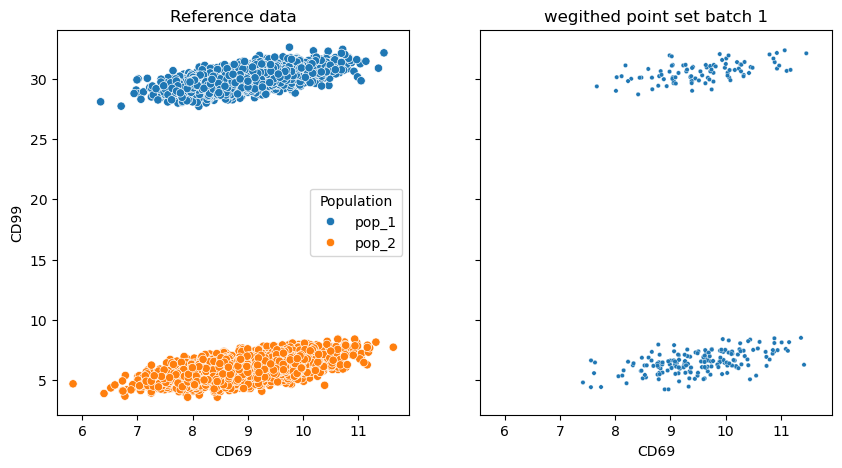

In [84]:
points_df_batch = pd.DataFrame(points)
points_df_batch.columns = ['CD69', 'CD99']
points_df_batch['weight'] = weights.to_numpy()


fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)

# plot the reference data first
sns.scatterplot(
    data=df[df['Batch'] == 'batch_1'],
    x='CD69',
    y='CD99',
    hue='Population',
    ax=ax[0]
).set_title("Reference data")

sns.scatterplot(
    data=points_df_batch,
    x='CD69',
    y='CD99',
    s=10+(weights*100),
    ax=ax[1]
).set_title("wegithed point set batch 1")


In [85]:
points_df['batch'] = 'ref'
points_df_batch['batch'] = 'batch_1'
points_df_concat = pd.concat([points_df, points_df_batch])
points_df_concat

,CD69,CD99,weight,batch
0,0.963761,14.189578,0.000122,ref
1,1.622713,13.931803,0.000140,ref
2,1.650243,14.295074,0.000245,ref
3,1.756376,15.134831,0.000175,ref
4,1.774289,2.471346,0.000140,ref
...,...,...,...,...
266,10.862899,31.687615,0.000283,batch_1
267,11.124901,7.429697,0.000124,batch_1
268,11.146709,8.147996,0.000212,batch_1
269,11.457808,32.118793,0.000159,batch_1


Text(0.5, 1.0, 'Generated weighted point')

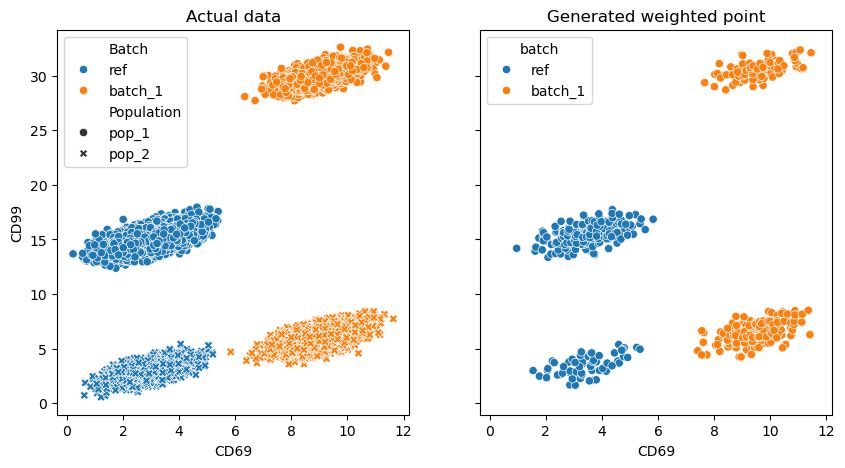

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)

# plot the reference data first
sns.scatterplot(
    data=df,
    x='CD69',
    y='CD99',
    hue='Batch',
    style='Population',
    ax=ax[0]
).set_title("Actual data")

sns.scatterplot(
    data=points_df_concat,
    x='CD69',
    y='CD99',
    hue='batch',
    ax=ax[1]
).set_title("Generated weighted point")


In [87]:
points_df_concat.shape

(562, 4)

# Try CPD rigid registration

I probably had too many points..

In [88]:
# create a RigidRegistration object
# X is target, Y is source
target = points_df_concat[points_df_concat['batch'] == 'ref'][['CD69', 'CD99']].to_numpy()
source = points_df_concat[points_df_concat['batch'] == 'batch_1'][['CD69', 'CD99']].to_numpy()

reg = RigidRegistration(X=target, Y=source)

In [89]:
TY, (s_reg, R_reg, t_reg) = reg.register()


In [90]:
df_batch_transformed

,CD69,CD99,batch
0,0.870005,13.769961,ref
1,1.705871,13.959882,ref
2,1.306268,14.714044,ref
3,1.251417,15.300006,ref
4,1.735808,2.252005,ref
...,...,...,...
266,4.250913,16.271988,batch_1
267,4.474251,3.861303,batch_1
268,4.663293,4.414320,batch_1
269,4.441009,16.047079,batch_1


Text(0.5, 1.0, 'Pre CPD')

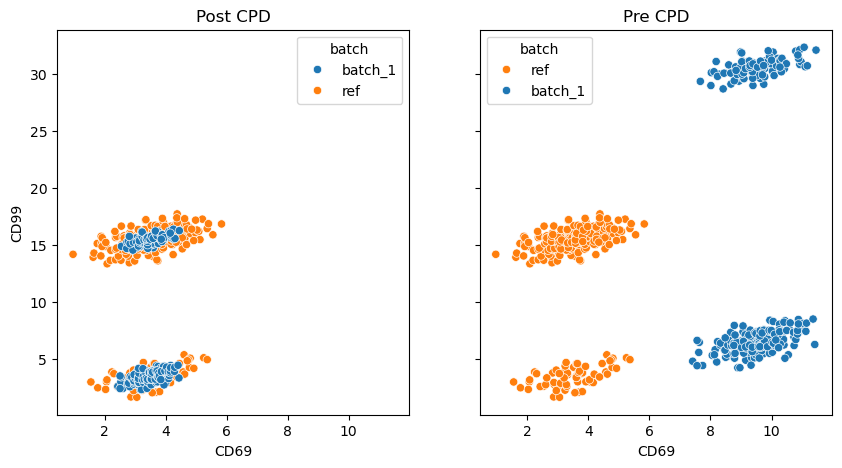

In [91]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

batch_df_transformed = pd.DataFrame(TY)
batch_df_transformed.columns = ['CD69', 'CD99']
batch_df_transformed['batch'] = 'batch_1'

target_df = points_df_concat[points_df_concat['batch'] == 'ref'][['CD69', 'CD99']]
target_df['batch'] = 'ref'

df_batch_transformed = pd.concat([target_df, batch_df_transformed])
df_batch_transformed['batch'] = pd.Categorical(df_batch_transformed['batch'], ordered=True)

sns.scatterplot(
    data=df_batch_transformed, 
    x="CD69", 
    y="CD99", 
    hue="batch",
    ax=ax[0],
    palette={"batch_1": "#1f77b4", "ref": "#ff7f0e"}
).set_title("Post CPD")

sns.scatterplot(
    data=points_df_concat,
    x='CD69',
    y='CD99',
    hue='batch',
    ax=ax[1],
    palette={"batch_1": "#1f77b4", "ref": "#ff7f0e"}
).set_title("Pre CPD")


Seems to work, but note, if the number of points set too high, the correction didn't work - the CD99- population was dragged to the top, which is strange.

# Knn?

Maybe premature, but first go.

In [94]:
ref_bin_id = np.repeat(bin_coords_over_threshold['bin_id'], num_points)
batch_bin_id = np.repeat(bin_coords_over_threshold_batch['bin_id'], num_points_batch)

df_batch_transformed['bin'] = np.concat([ref_bin_id, batch_bin_id])
df_batch_transformed


,CD69,CD99,batch,bin
0,0.963761,14.189578,ref,bin_55
1,1.622713,13.931803,ref,bin_119
2,1.650243,14.295074,ref,bin_120
3,1.756376,15.134831,ref,bin_121
4,1.774289,2.471346,ref,bin_130
...,...,...,...,...
266,4.148798,16.049492,batch_1,bin_542
267,4.287004,3.911919,batch_1,bin_547
268,4.297705,4.271332,batch_1,bin_548
269,4.446339,16.265411,batch_1,bin_574


In [102]:
# TODO have to fix this.. 
pop_ref = [
    'pop_1' if x > 12 else 'pop_2' for x in df_batch_transformed[df_batch_transformed['batch'] == 'ref']['CD99'].values
]
pop_batch = np.repeat('na', df_batch_transformed[df_batch_transformed['batch'] == 'batch_1'].shape[0])

df_batch_transformed['population'] = np.concat([pop_ref, pop_batch])
df_batch_transformed

,CD69,CD99,batch,bin,population
0,0.963761,14.189578,ref,bin_55,pop_1
1,1.622713,13.931803,ref,bin_119,pop_1
2,1.650243,14.295074,ref,bin_120,pop_1
3,1.756376,15.134831,ref,bin_121,pop_1
4,1.774289,2.471346,ref,bin_130,pop_2
...,...,...,...,...,...
266,4.148798,16.049492,batch_1,bin_542,na
267,4.287004,3.911919,batch_1,bin_547,na
268,4.297705,4.271332,batch_1,bin_548,na
269,4.446339,16.265411,batch_1,bin_574,na


In [107]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(
    df_batch_transformed[df_batch_transformed['batch'] == 'ref'][['CD69', 'CD99']].to_numpy(), 
    df_batch_transformed[df_batch_transformed['batch'] == 'ref']['population'].to_numpy()
)

pred_batch_1 = neigh.predict(df_batch_transformed[df_batch_transformed['batch'] == 'batch_1'][['CD69', 'CD99']].to_numpy())
df_batch_transformed['population'] = np.concat([pop_ref, pred_batch_1])


Text(0.5, 1.0, 'Pre CPD')

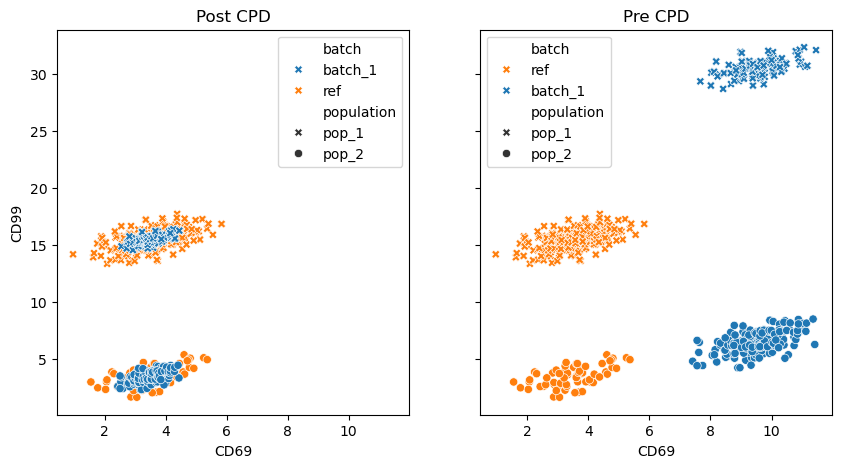

In [109]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

sns.scatterplot(
    data=df_batch_transformed, 
    x="CD69", 
    y="CD99", 
    hue="batch",
    ax=ax[0],
    palette={"batch_1": "#1f77b4", "ref": "#ff7f0e"},
    style='population', 
    markers={'pop_1': 'X', 'pop_2': 'o'}
).set_title("Post CPD")

pop_bin = [
    'pop_1' if x > 12 else 'pop_2' for x in points_df_concat['CD99'].values
]
points_df_concat['population'] = pop_bin

sns.scatterplot(
    data=points_df_concat,
    x='CD69',
    y='CD99',
    hue='batch',
    ax=ax[1],
    palette={"batch_1": "#1f77b4", "ref": "#ff7f0e"},
    style='population', 
    markers={'pop_1': 'X', 'pop_2': 'o'}
    
).set_title("Pre CPD")
